In [119]:
# learning from https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [120]:
cal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
submission = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
sellprice = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')

days = [d for d in train.columns if 'd_' in d]

# Visualizing data for Walmart Sales
* The data contains sales divided into 3 categories: food, hobby and household
* It is further divided base on location of the store, there are 3 stores each in CA, TX and WI
* The sales data contains date from 2011-01-29 through 2016-06-19
* There is a 'calender' file that labels holidays throughout the year

# Item with the most and least sales
* Top 5 are all in the 'Food' category, highest sale is over 20k
* Bottom 5 are extremely low consider the time frame is over 5 years. The product might only be recently added or only existed for a short period of time


In [121]:
# total sales over 1913 days of a product
train['total_sale'] = train.loc[:,days].sum(axis=1)

# sort items by sale
print(train['total_sale'].sort_values())
print('\n')


# index of an item
print(train.index[train.id == 'FOODS_3_090_CA_3_validation'][0])
print('\n')

6682         10
6048         12
27606        13
20192        16
26276        16
          ...  
2314     127203
8908     134386
21104    150122
18055    192835
8412     250502
Name: total_sale, Length: 30490, dtype: int64


8412




In [122]:
# item most sold
print('Top 5:')
print(train.loc[8412,'id'].replace('_validation',''), ':', train.loc[8412,'total_sale'])
print(train.loc[18055,'id'].replace('_validation',''), ':', train.loc[18055,'total_sale'])
print(train.loc[21104,'id'].replace('_validation',''), ':', train.loc[21104,'total_sale'])
print(train.loc[8908,'id'].replace('_validation',''), ':', train.loc[8908,'total_sale'])
print(train.loc[2314,'id'].replace('_validation',''), ':', train.loc[2314,'total_sale'])

print('\n')

# item least sold
print('Bottom 5:')
print(train.loc[6682,'id'].replace('_validation',''), ':', train.loc[6682,'total_sale'])
print(train.loc[6048,'id'].replace('_validation',''), ':', train.loc[6048,'total_sale'])
print(train.loc[27606,'id'].replace('_validation',''), ':', train.loc[27606,'total_sale'])
print(train.loc[20192,'id'].replace('_validation',''), ':', train.loc[20192,'total_sale'])
print(train.loc[26276,'id'].replace('_validation',''), ':', train.loc[26276,'total_sale'])

Top 5:
FOODS_3_090_CA_3 : 250502
FOODS_3_586_TX_2 : 192835
FOODS_3_586_TX_3 : 150122
FOODS_3_586_CA_3 : 134386
FOODS_3_090_CA_1 : 127203


Bottom 5:
HOUSEHOLD_1_020_CA_3 : 10
FOODS_3_778_CA_2 : 12
HOBBIES_1_170_WI_3 : 13
FOODS_2_071_TX_3 : 16
FOODS_2_057_WI_2 : 16


# Daily sale of an item
* *FOODS_3_090_CA* is the highest sale item
* The sale goes up and down and sometimes zero, maybe this is due to product out of stock

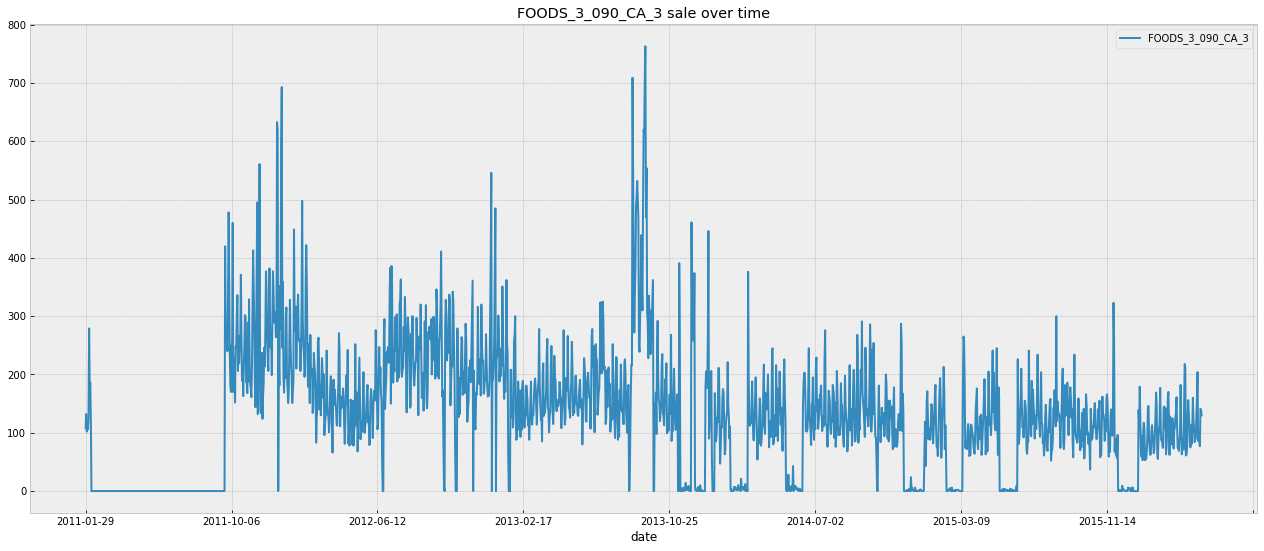

In [123]:
# function to plot sale of any item, given 'id'
# matchs days in actual date
def plot_item(item_name):
        
    sale = train.loc[train.id == item_name, days].T # get daily sales, then transpose
    
    item_index = train.index[train.id == item_name][0] # index of this item
   
    item_name = item_name.replace('_validation','') # remove _validation
           
    sale = sale.rename(columns={item_index:item_name}) # rename column to item name
    sale = sale.reset_index().rename(columns={'index':'d'}) #re name column to d
    sale = sale.merge(cal, how='left', validate='1:1') # merge
    sale = sale.set_index('date')[item_name] # just keep the columns we need
    
    sale.plot(figsize=(22,9),lw=2)
    plt.title(f'{item_name} sale over time')
    plt.legend([item_name])
    plt.show()

# top 3
plot_item('FOODS_3_090_CA_3_validation')
# plot_item('FOODS_3_586_TX_2_validation')
# plot_item('FOODS_3_586_TX_3_validation')     

# bottom 3
#plot_item('HOUSEHOLD_1_020_CA_3_validation')
#plot_item('FOODS_3_778_CA_2_validation')
#plot_item('HOBBIES_1_170_WI_3_validation')

# Sale of an item by day/month/year
## Take a look at the top 3 items
* It is clear the sale peaks at day = 1,2 (Saturday and Sunday), then drops and raise again as towards end of a week
* The peak for month is in August, while this might differ from item to item
* The items had really high sales in year 2011-2012, it reduced dramatically in recent years

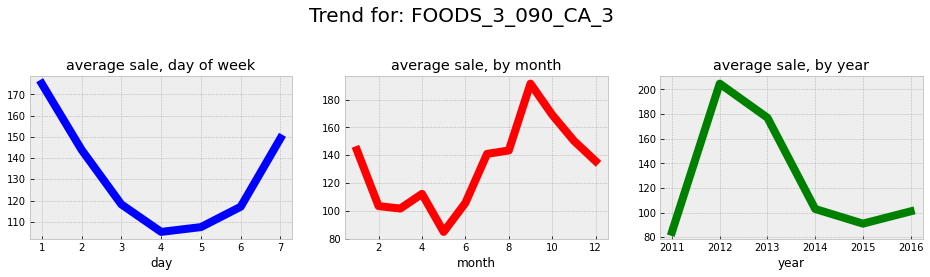

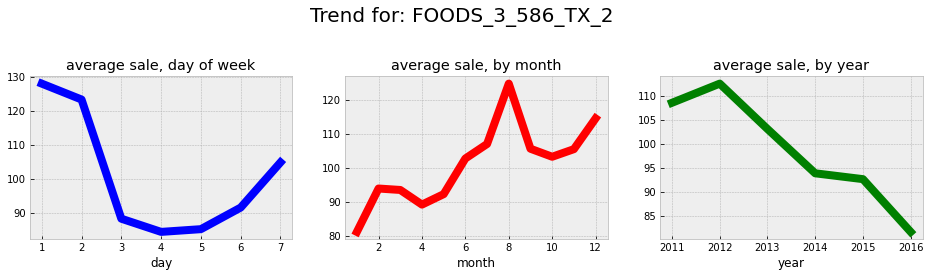

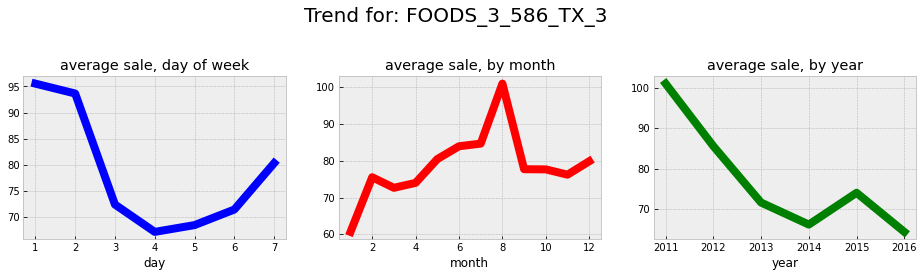

In [124]:
# function to plot sale of any item, given 'id'
# by week/month/year

def plot_by_wmy(item_name):

    # one row, 3 column
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,3))
    
    sale = train.loc[train.id == item_name, days].T # get daily sales, then transpose

    item_index = train.index[train.id == item_name][0] # index of this item

    item_name = item_name.replace('_validation','') # remove _validation

    sale = sale.rename(columns={item_index:item_name}) # rename column to item name
    sale = sale.reset_index().rename(columns={'index':'d'}) #re name column to d
    sale = sale.merge(cal, how='left', validate='1:1') # merge

    sale_day = sale.groupby('wday')[item_name].mean() # mean sale by day of week
    sale_month = sale.groupby('month')[item_name].mean() # mean sale by day of week
    sale_year = sale.groupby('year')[item_name].mean() # mean sale by day of week

    sale_day.plot(kind='line',lw=8,title='average sale, day of week',color='blue',ax=ax1) # plot by day
    sale_month.plot(kind='line',lw=8,title='average sale, by month', color='red',ax=ax2) # plot by month
    sale_year.plot(kind='line',lw=8,title='average sale, by year',color='green',ax=ax3) # plot by year
    
    ax1.set_xlabel('day')

    fig.suptitle(f'Trend for: {item_name}' ,size=20,y=1.2) # title

    plt.show()

plot_by_wmy('FOODS_3_090_CA_3_validation')
plot_by_wmy('FOODS_3_586_TX_2_validation')
plot_by_wmy('FOODS_3_586_TX_3_validation')

# Proportion of goods in Walmart
* Nearly 50% of Walmart commodities are in the 'Food' category
* Around 30% are 'Household' 
* Around 20% are 'Hobbies'

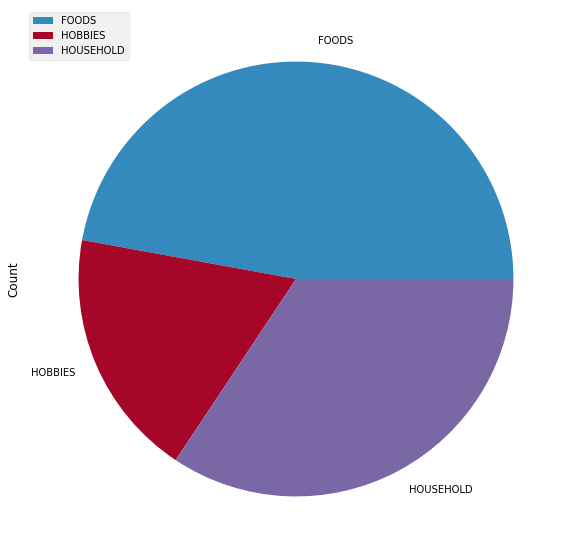

In [125]:
# total number of goods in each category

a = pd.DataFrame(train.groupby('cat_id').count()['id'])
a = a.rename(columns={'id':'Count'})

a.plot.pie(y='Count', figsize=(10,10))
plt.legend(loc='upper left')
plt.show()

# Sale by each category over time

* Overall, all three categories sees a raise over time
* 'Food' raised a lot from year 2011-2012
* 'Household' saw a sharp raise in June 2012
* 'Hobbies' growing slowly

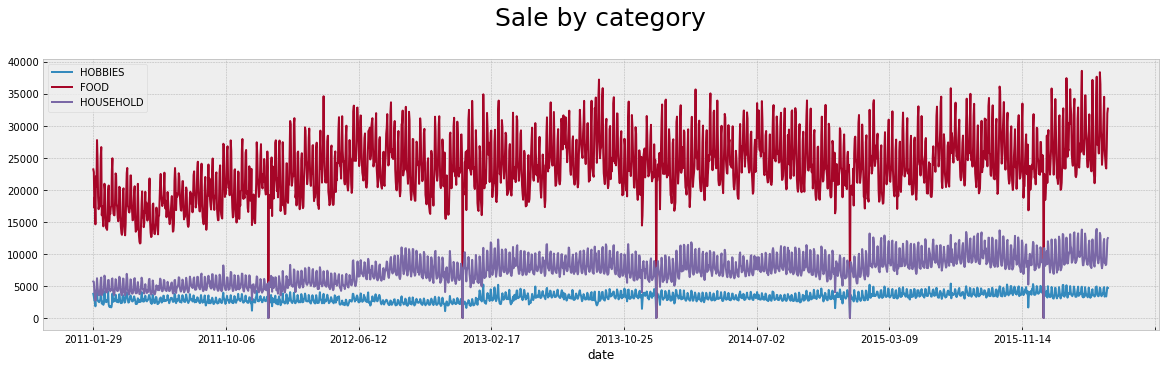

In [126]:
# Sale of each Category each day

a =train.set_index('id')[days].T  # d, item1, item2 ...
b =cal.set_index('d')['date']     # d, date

past_sales = a.merge(b, left_index=True, right_index=True, validate='1:1').set_index('date') # date, item1, item2 ...


items_col = [c for c in past_sales.columns if 'HOBBIES' in c]
past_sales[items_col].sum(axis=1).plot(kind='line',figsize=(20,5))

items_col = [c for c in past_sales.columns if 'FOOD' in c]
past_sales[items_col].sum(axis=1).plot(kind='line',figsize=(20,5))

items_col = [c for c in past_sales.columns if 'HOUSEHOLD' in c]
past_sales[items_col].sum(axis=1).plot(kind='line',figsize=(20,5))

plt.title('Sale by category',y=1.1, size=25)
plt.legend(['HOBBIES','FOOD','HOUSEHOLD'])

plt.show()

# Sales by Store Name over time
* All store experience cycles in sales over the course of a year
* *CA_3* has the highest overall
* *CA_2* saw a sharp raise after April 2015
* *WI_2* saw a sharp raise after May 2012
* *WI_2* saw a sharp raise in the end of 2012
* Texas stores are fairly steady

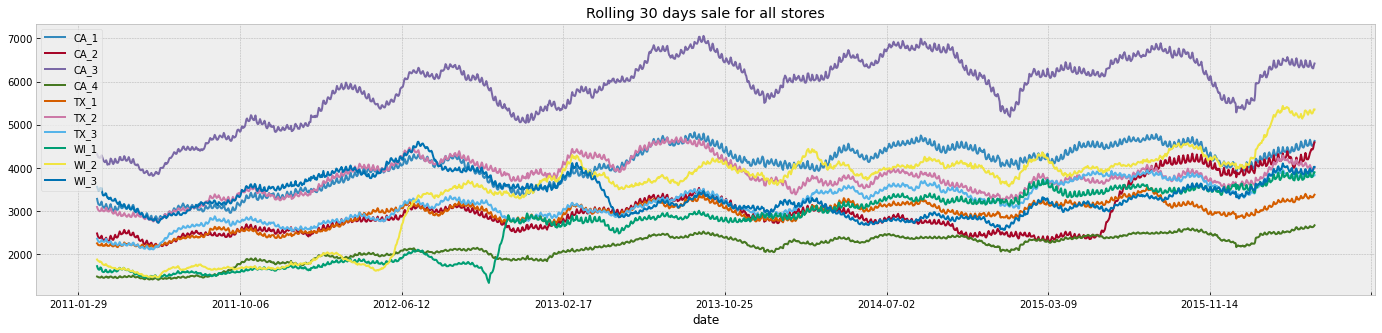

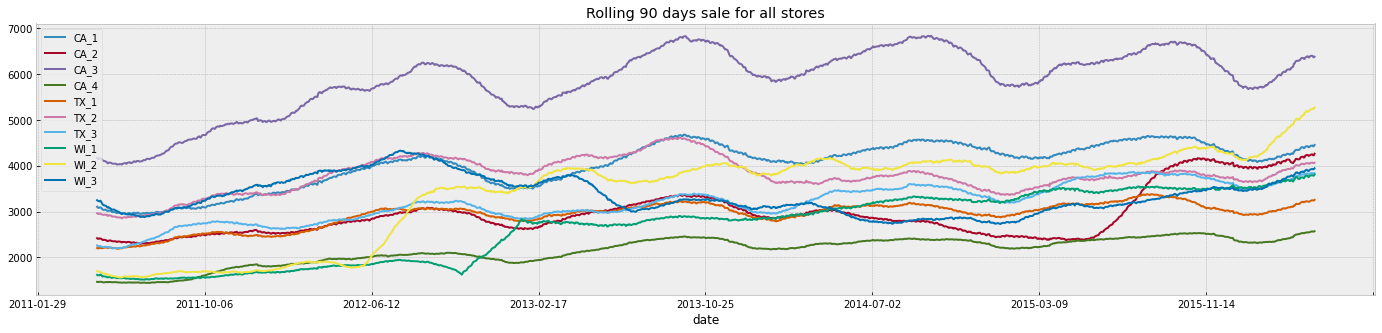

In [127]:
# rolling mean sales by store
store_list = train.store_id.unique()
store_list

a = train.groupby('store_id')[days].sum().T # d, store
b =cal.set_index('d')['date']     # d, date

store_sales = a.merge(b, left_index=True, right_index=True, validate='1:1').set_index('date') # date, store


# rolling 30 days
plt.figure(figsize=(24,5))

for store in store_list:
    
    store_sales[store].rolling(30).mean().plot(kind='line')

plt.title('Rolling 30 days sale for all stores')
plt.legend(store_list)
plt.show()


# rolling 90 days
plt.figure(figsize=(24,5))

for store in store_list:
    
    store_sales[store].rolling(90).mean().plot(kind='line')

plt.title('Rolling 90 days sale for all stores')
plt.legend(store_list)
plt.show()

# Rolling 7 days sale by store
## These show the same pattern as observed above

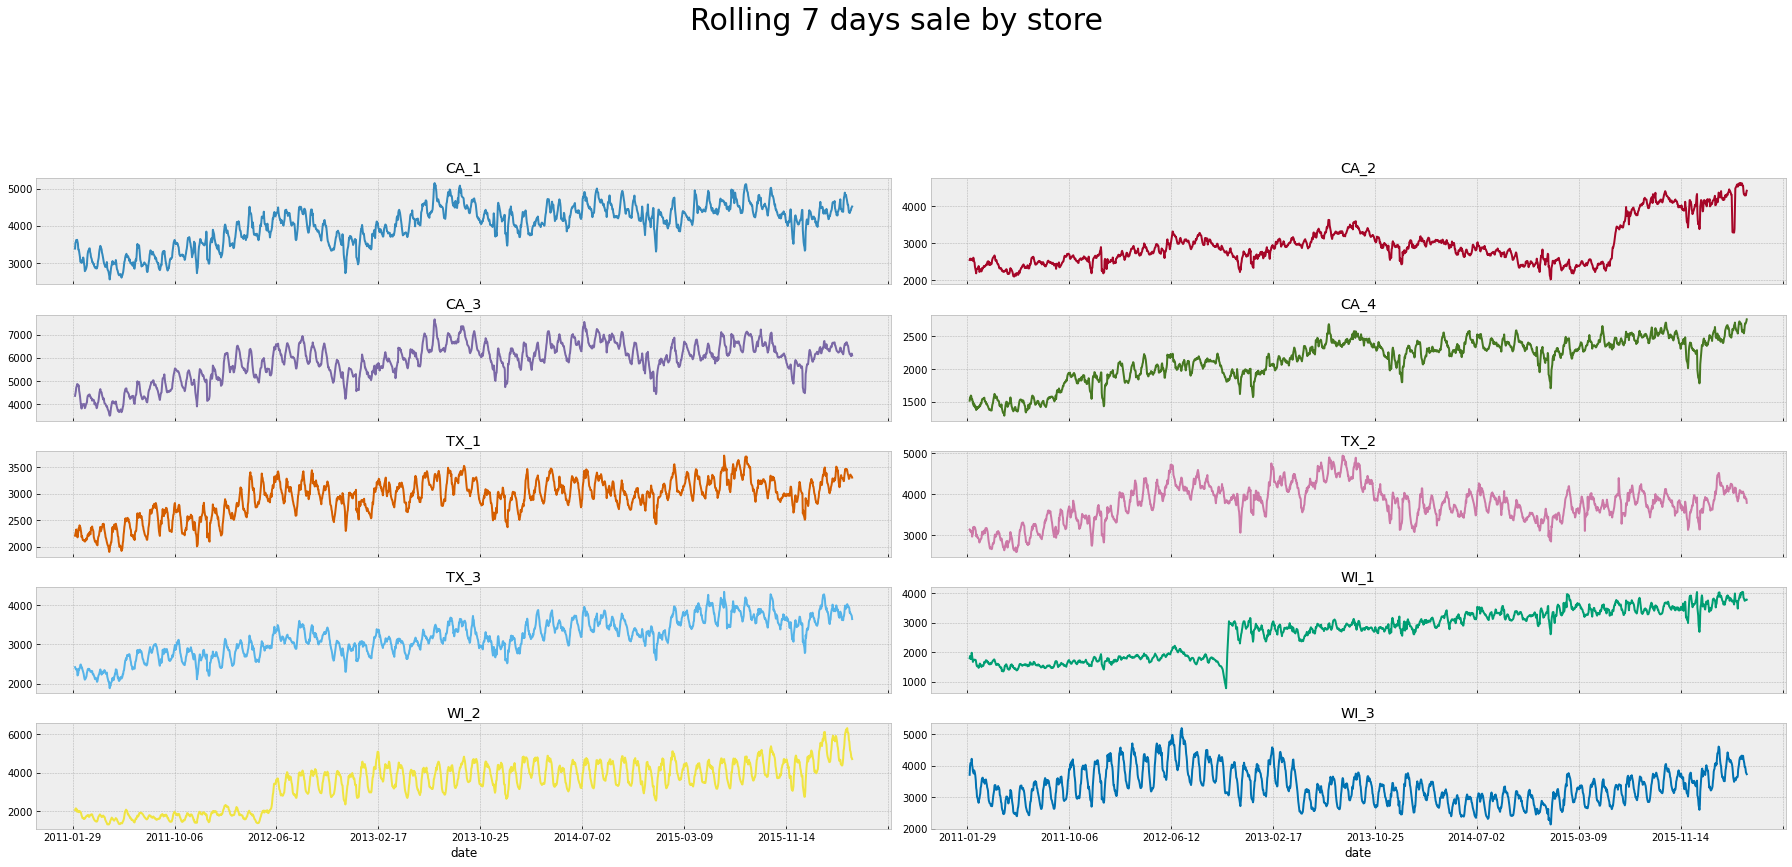

In [128]:
# Rolling 7 day sales by store

fig, axes = plt.subplots(5,2,figsize=(25,10), sharex=True)

axes = axes.flatten()

ax_idx = 0

for store in store_list:
    
    store_sales[store].rolling(7).mean().plot(kind='line',title=store, lw = 2, color=next(color_cycle), ax=axes[ax_idx])
    
    ax_idx += 1

plt.suptitle('Rolling 7 days sale by store', size=30, y=1.2)
plt.tight_layout()
plt.show()

# Min and Max daily sales
* The lowest sales are on Christmas Day, no suprise
* The highest days are worth more investigation, includes days before the date

* For example, on 2016-03-06, Seventh Democratic presidential candidates debate hosted by CNN and held in Flint, Michigan
* on 2016-02-06 Eighth Republican presidential candidates debate hosted by ABC, held in Goffstown, New Hampshire

In [129]:
# sort days by sales, min to max
a = pd.DataFrame(store_sales.sum(axis=1).sort_values(),columns=['Sale'])
a

,Sale
date,
2012-12-25,11
2011-12-25,13
2015-12-25,14
2013-12-25,20
2014-12-25,20
...,...
2015-10-03,54687
2016-02-06,55040
2016-04-09,56340


In [130]:
# preping for heatmap 52weeks

a = train.groupby('cat_id')[days].sum().T # d, store
b = cal.set_index('d').loc[:,['date','wday','month','weekday']]     # d, date

store_sales = a.merge(b, left_index=True, right_index=True, validate='1:1').set_index('date') # date, store

store_sales.index = pd.to_datetime(store_sales.index) # make index date format


In [131]:
# everyday sale by weekdays, (FOODS HOBBIES HOUSEHOLD), (start date), (year), rolling 364 day

def heatmap_52weeks(cat_id,start_date,year):
    
    # pick the dates, then reset index so can add columns in new DF
    sale = store_sales.loc[store_sales.index.isin(pd.date_range(start=start_date, periods=364))]
    sale = sale.reset_index()
    
    # new df used for plot
    # intialize a DF
    sale_week = pd.DataFrame({'day':['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],'week 1':sale[cat_id][0:7]})

    # add columns week 2:52
    for i in range(1,52):
         sale_week[f'week {i+1}'] = sale.loc[i*7 : i*7+7,cat_id].reset_index()[cat_id]

    
    sale_week = sale_week.set_index('day')
 
    plt.figure(figsize=(25,5))
    sns.heatmap(sale_week, square=True, cmap='seismic')
    plt.title(f'{cat_id}: Year {year}')
    plt.show()


# 'Food' sale per day from year 2012-2015
* It is clear that Saturday and Sunday are days with high demands, this trend carries over a bit to Monday and Friday
* In the middle of the week, there tends to be few sales
* There is always less sale around week 4 and week 48
* There seems to be some cyclis pattern as well, maybe people make big shopping roughly every 4 weeks?

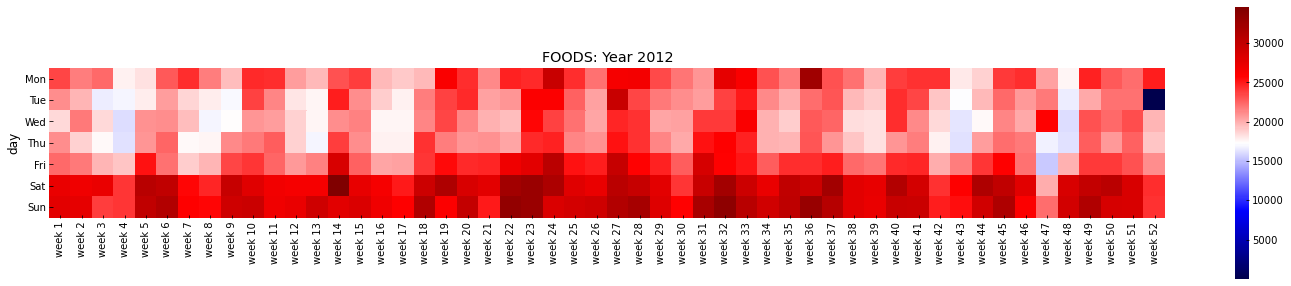

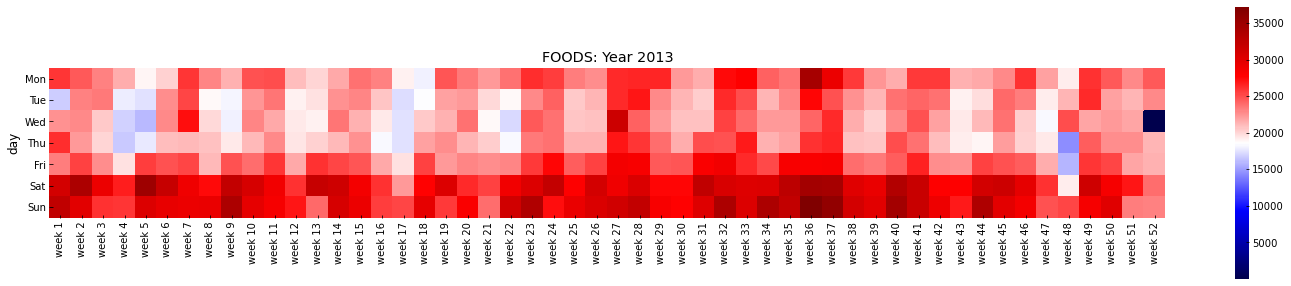

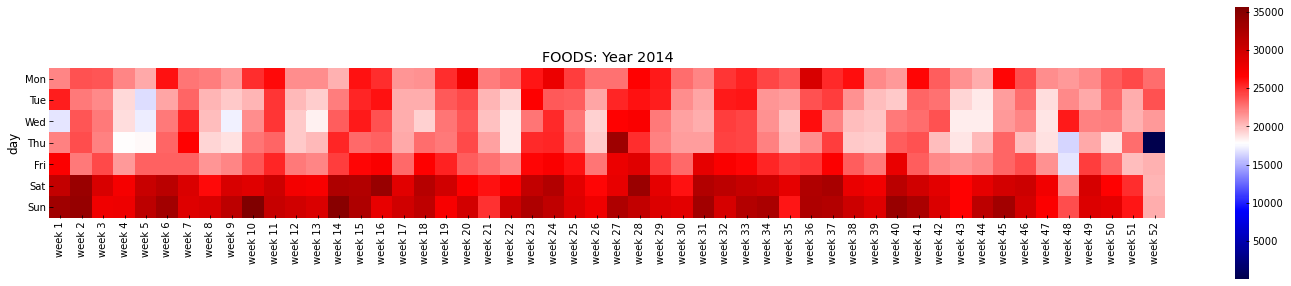

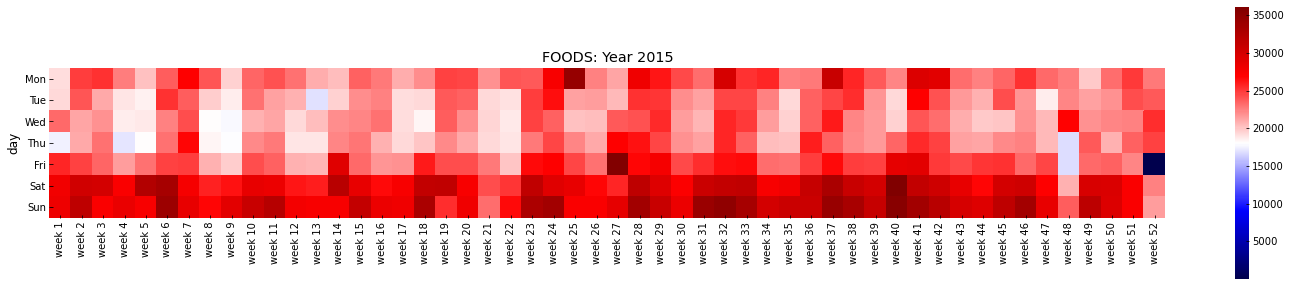

In [132]:
# food 
heatmap_52weeks('FOODS','2012-01-02', '2012')
heatmap_52weeks('FOODS','2012-12-31', '2013')
heatmap_52weeks('FOODS','2013-12-30', '2014')
heatmap_52weeks('FOODS','2014-12-29', '2015')

# 'Hobbies' sale per day from year 2012-2015
* High sales over the weekend, already see the raise on Friday
* Always very low sale on a Thursday in week 47/48, due to Thanks Giving
* Very low sale in early year of 2013
* In year 2014 and 2015, the sales are fairly high everyday in the last few weeks of the year

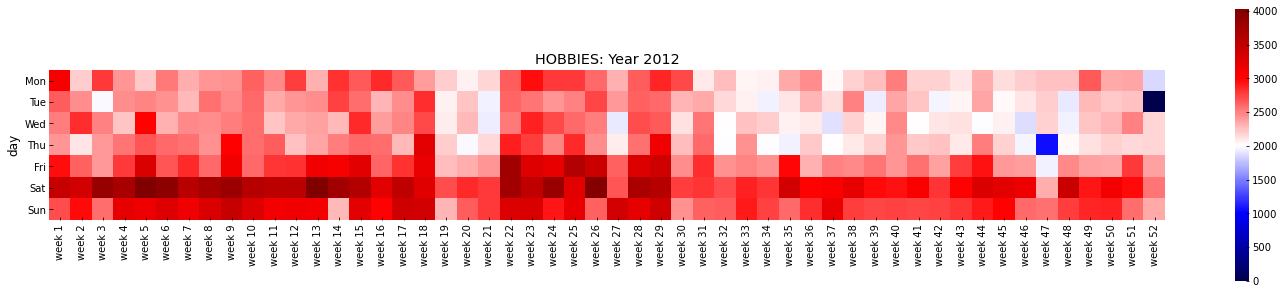

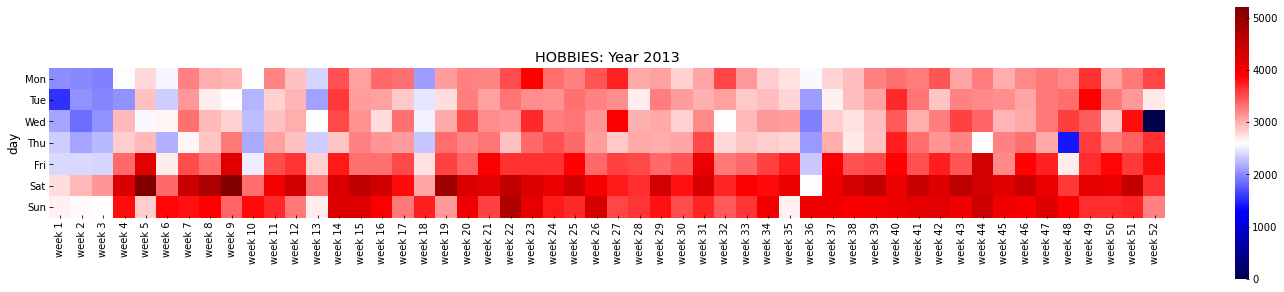

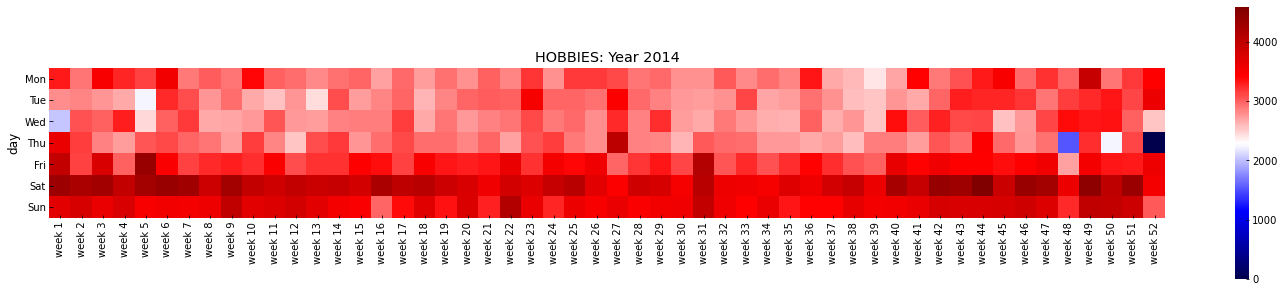

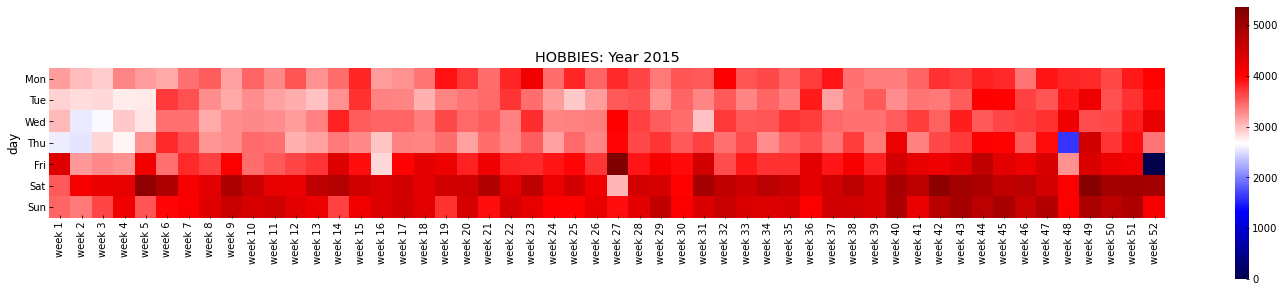

In [133]:
# hobby
heatmap_52weeks('HOBBIES','2012-01-02', '2012')
heatmap_52weeks('HOBBIES','2012-12-31', '2013')
heatmap_52weeks('HOBBIES','2013-12-30', '2014')
heatmap_52weeks('HOBBIES','2014-12-29', '2015')

# 'Household' sale per day from year 2012-2015
* High sales over the weekend
* Lower sales on weekdays
* Usually low sales in the beginning of a year, this trend persisted very long in year 2012 all the way til week 23
* Very low sale on Thanks Giving

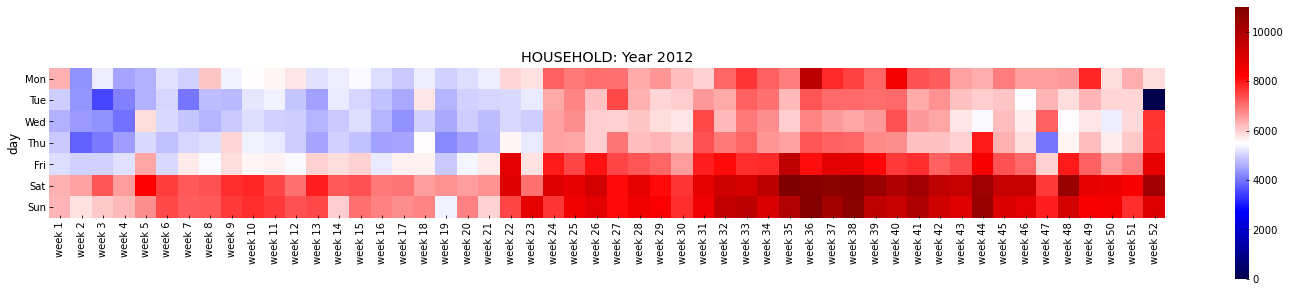

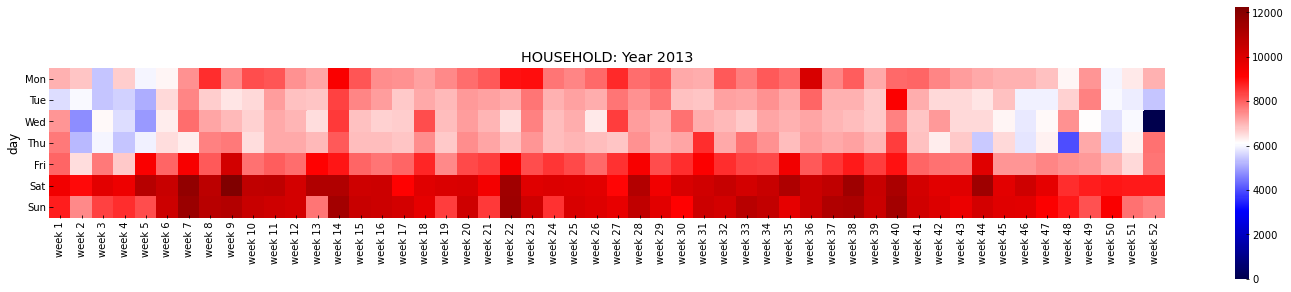

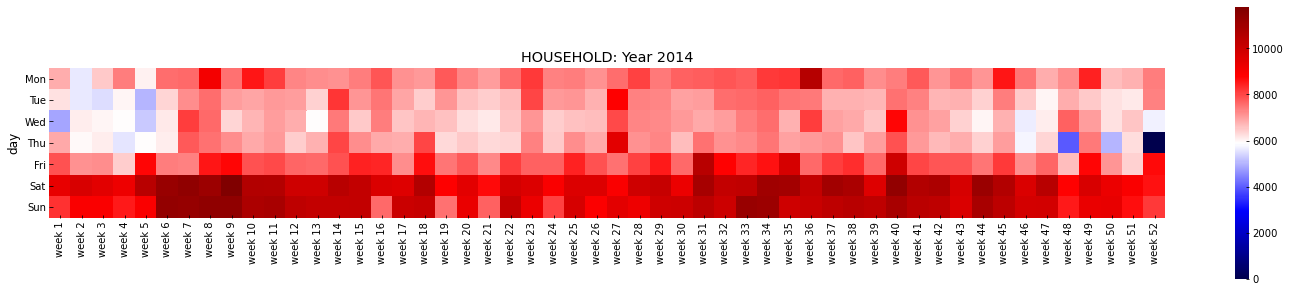

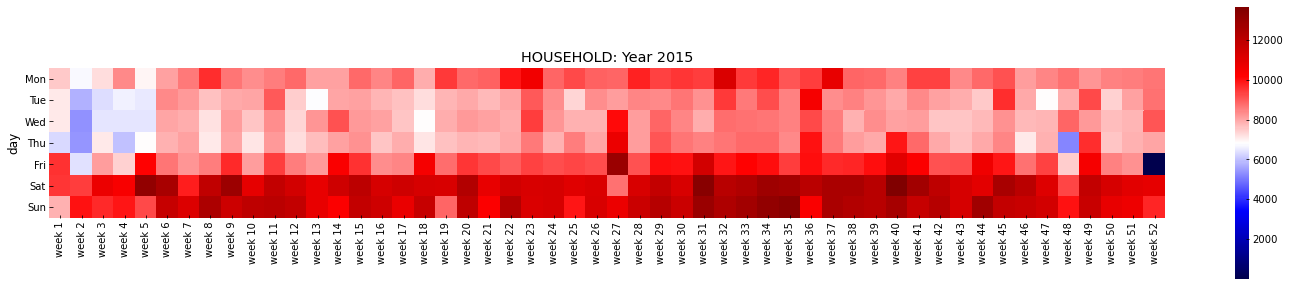

In [134]:
# household
heatmap_52weeks('HOUSEHOLD','2012-01-02', '2012')
heatmap_52weeks('HOUSEHOLD','2012-12-31', '2013')
heatmap_52weeks('HOUSEHOLD','2013-12-30', '2014')
heatmap_52weeks('HOUSEHOLD','2014-12-29', '2015')

# Price of an item over time
* The price changes over time
* Usually it is an upward trend, but it can vary from product to product, and also different by the stores

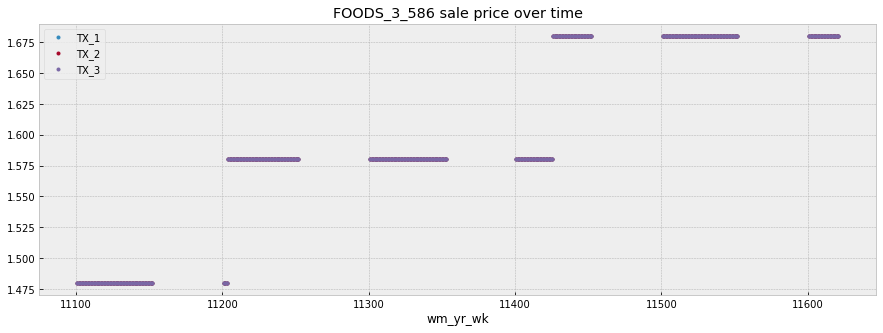

In [135]:
store_list = train.store_id.unique()
store_list

# function that produce trend of price over time, given 'item name', list of stores

def price_over_time(item_name,store_names):
    fig, ax = plt.subplots(figsize=(22, 5))
    
    for SS in store_names:

        prices = sellprice.loc[sellprice.item_id == item_name].loc[sellprice.store_id == SS]
        prices = prices.loc[:,['wm_yr_wk','sell_price']]

        prices.plot(x='wm_yr_wk',
                  y='sell_price',
                  style='.',
                  color=next(color_cycle),
                  figsize=(15, 5),
                  title=f'{item_name} sale price over time',
                  ax=ax
                )
    
    plt.legend(store_names)
    plt.show()

price_over_time('FOODS_3_586',['TX_1','TX_2','TX_3'])

In [136]:
# preping for holiday effect

a = train.groupby('cat_id')[days].sum().T # d, store
b = cal.set_index('d').loc[:,['date','wday','month','weekday','event_name_1','event_type_1']] # d, date

store_sales = a.merge(b, left_index=True, right_index=True, validate='1:1').set_index('date') # date, store

store_sales.index = pd.to_datetime(store_sales.index) # make index date format

ss = store_sales

# list all of holiday, remove NaN
events = ss.event_name_1.unique()
events = events[1:len(events)]
events

array(['SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

# Effect of holidays on 'Food'
* Noticeable differences: Superbowl, Purim End, OrthodoxEaster, Mother's day, Father's day, IndependenceDay, Ramadan starts, Eid al-Fitr, LaborDay, ColumbusDay, VeteransDay, OrthodoxChristmas, Easter
* Noticeable lower on the holiday: Halloween, Thanksgiving, Christmas, NewYear

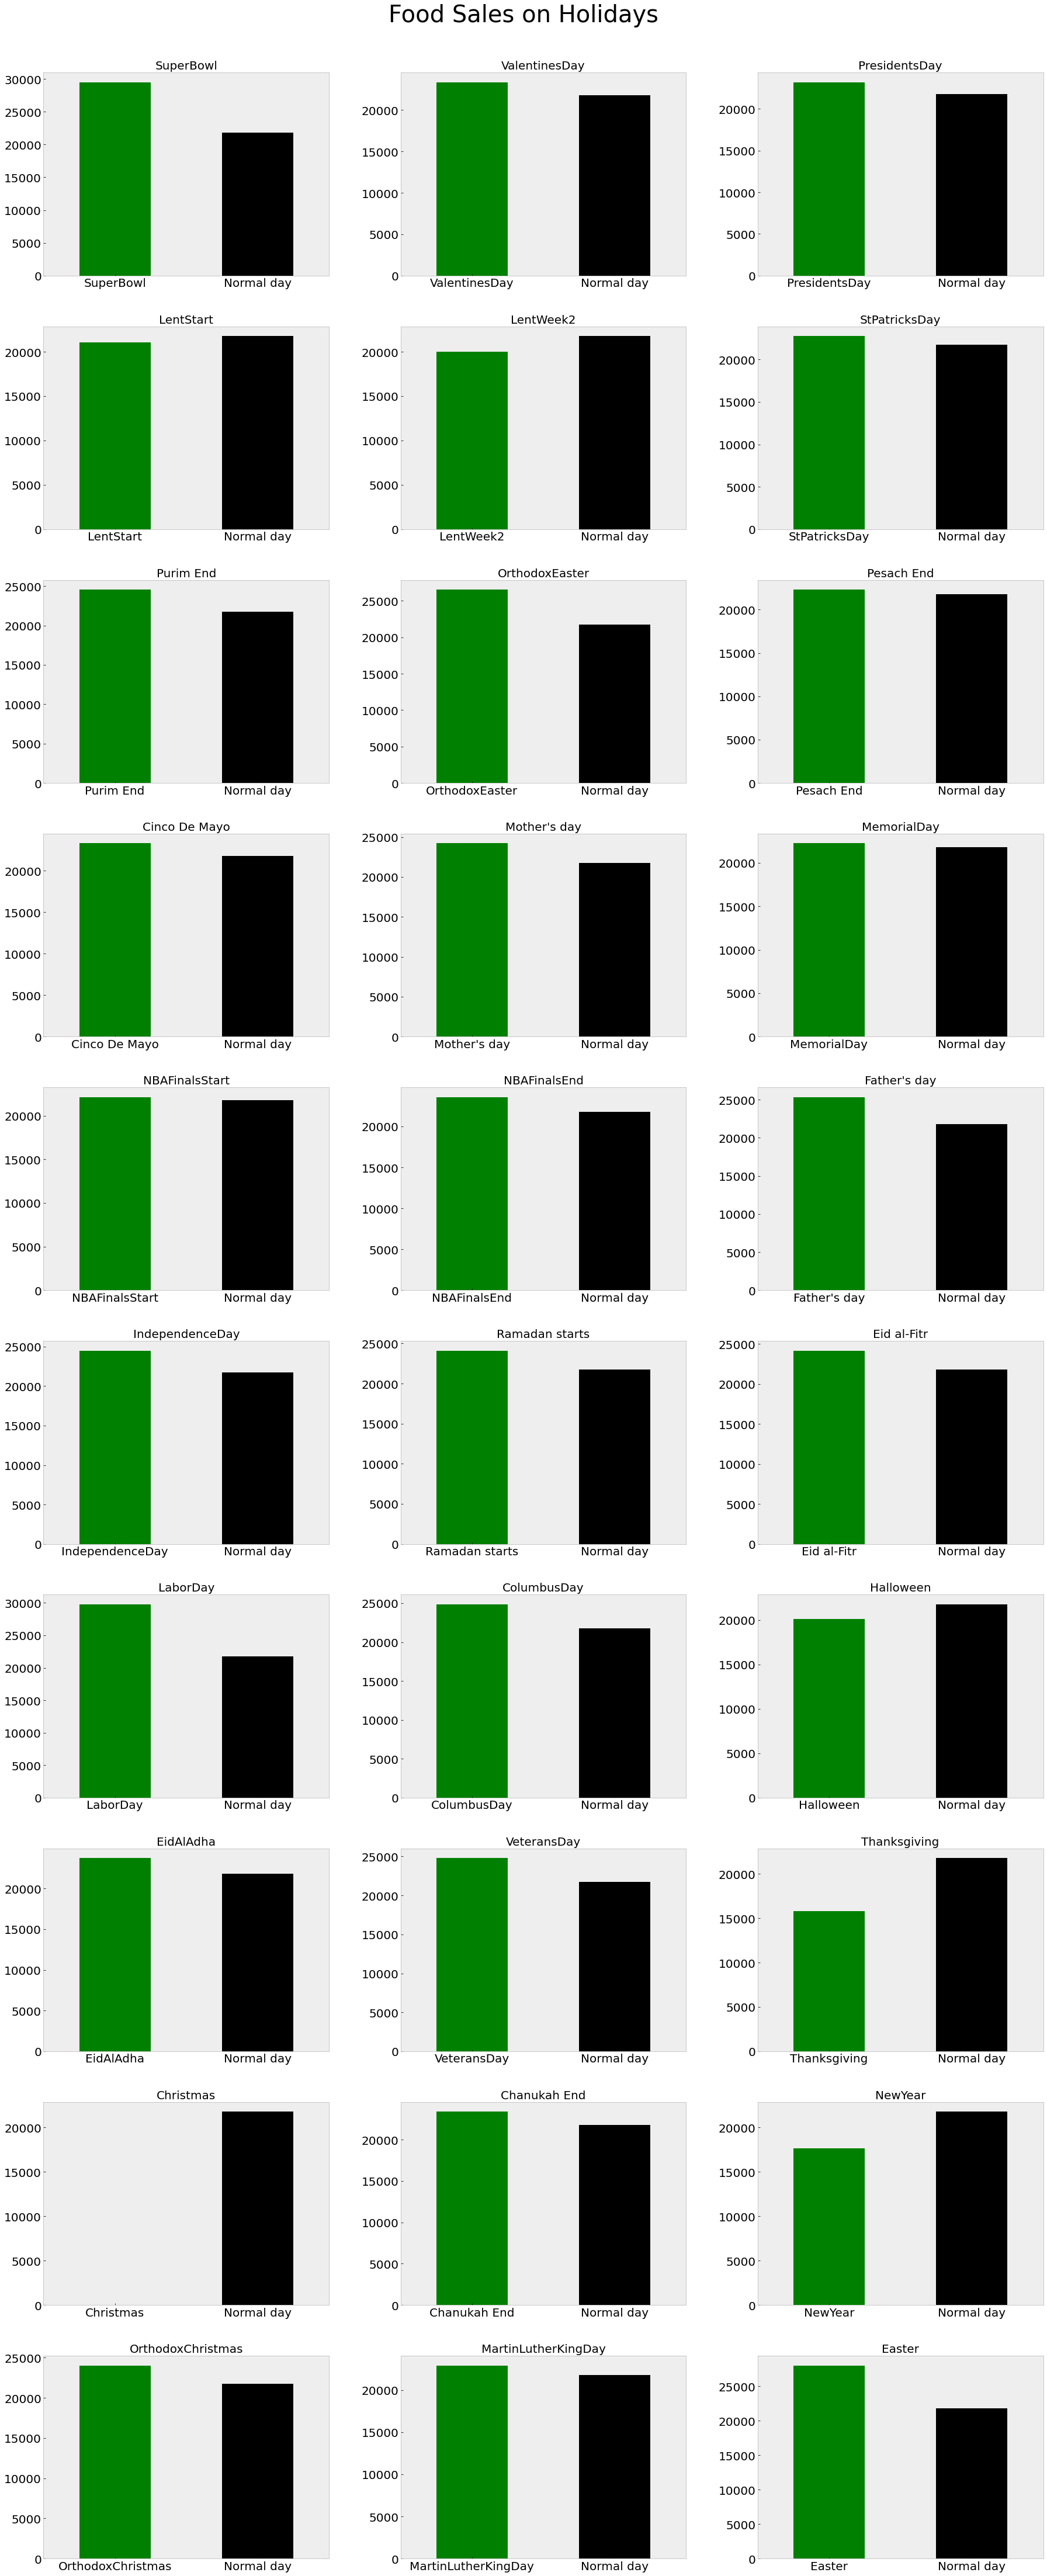

In [137]:
# FOOD sale on holiday
fig, axes = plt.subplots(10,3,figsize=(25,60))

axes = axes.flatten()
ax_idx = 0


for ee in events:
    
    normal_day_sales = ss.loc[(ss.event_name_1.isnull()) & (ss.weekday != 'Saturday') & (ss.weekday != 'Sunday')] # sales on normal day
    nm = normal_day_sales['FOODS'].mean()  

    event_day = ss.loc[(ss.event_name_1 == ee)] # sale on the holiday
    em = event_day['FOODS'].mean()

    df = pd.DataFrame({'Type':[ee,'Normal day'],'Sale':[em,nm]}) # make new df
    
    df.plot(kind='bar',x='Type',y='Sale', title= ee, legend='', rot=0, color=['green','black'], ax=axes[ax_idx])
    
    axes[ax_idx].set_title(ee, fontsize=20)
    axes[ax_idx].tick_params(axis='both', which='major', labelsize=20) # x y tick font size
    axes[ax_idx].set_xlabel('') # remove x label
    axes[ax_idx].grid(False) # remove grid
    
    ax_idx +=1
    
plt.tight_layout()
plt.suptitle('Food Sales on Holidays', size=40, y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
    
    

# Effect of holidays on 'Hobbies'
* Noticeable differences: Superbowl, Purim End, OrthodoxEaster, Pesach End, Father's Day
* Noticeable lower on the holiday: Independence Day, Thanks Giving, Christmas, New Year, Orthodox Christmas

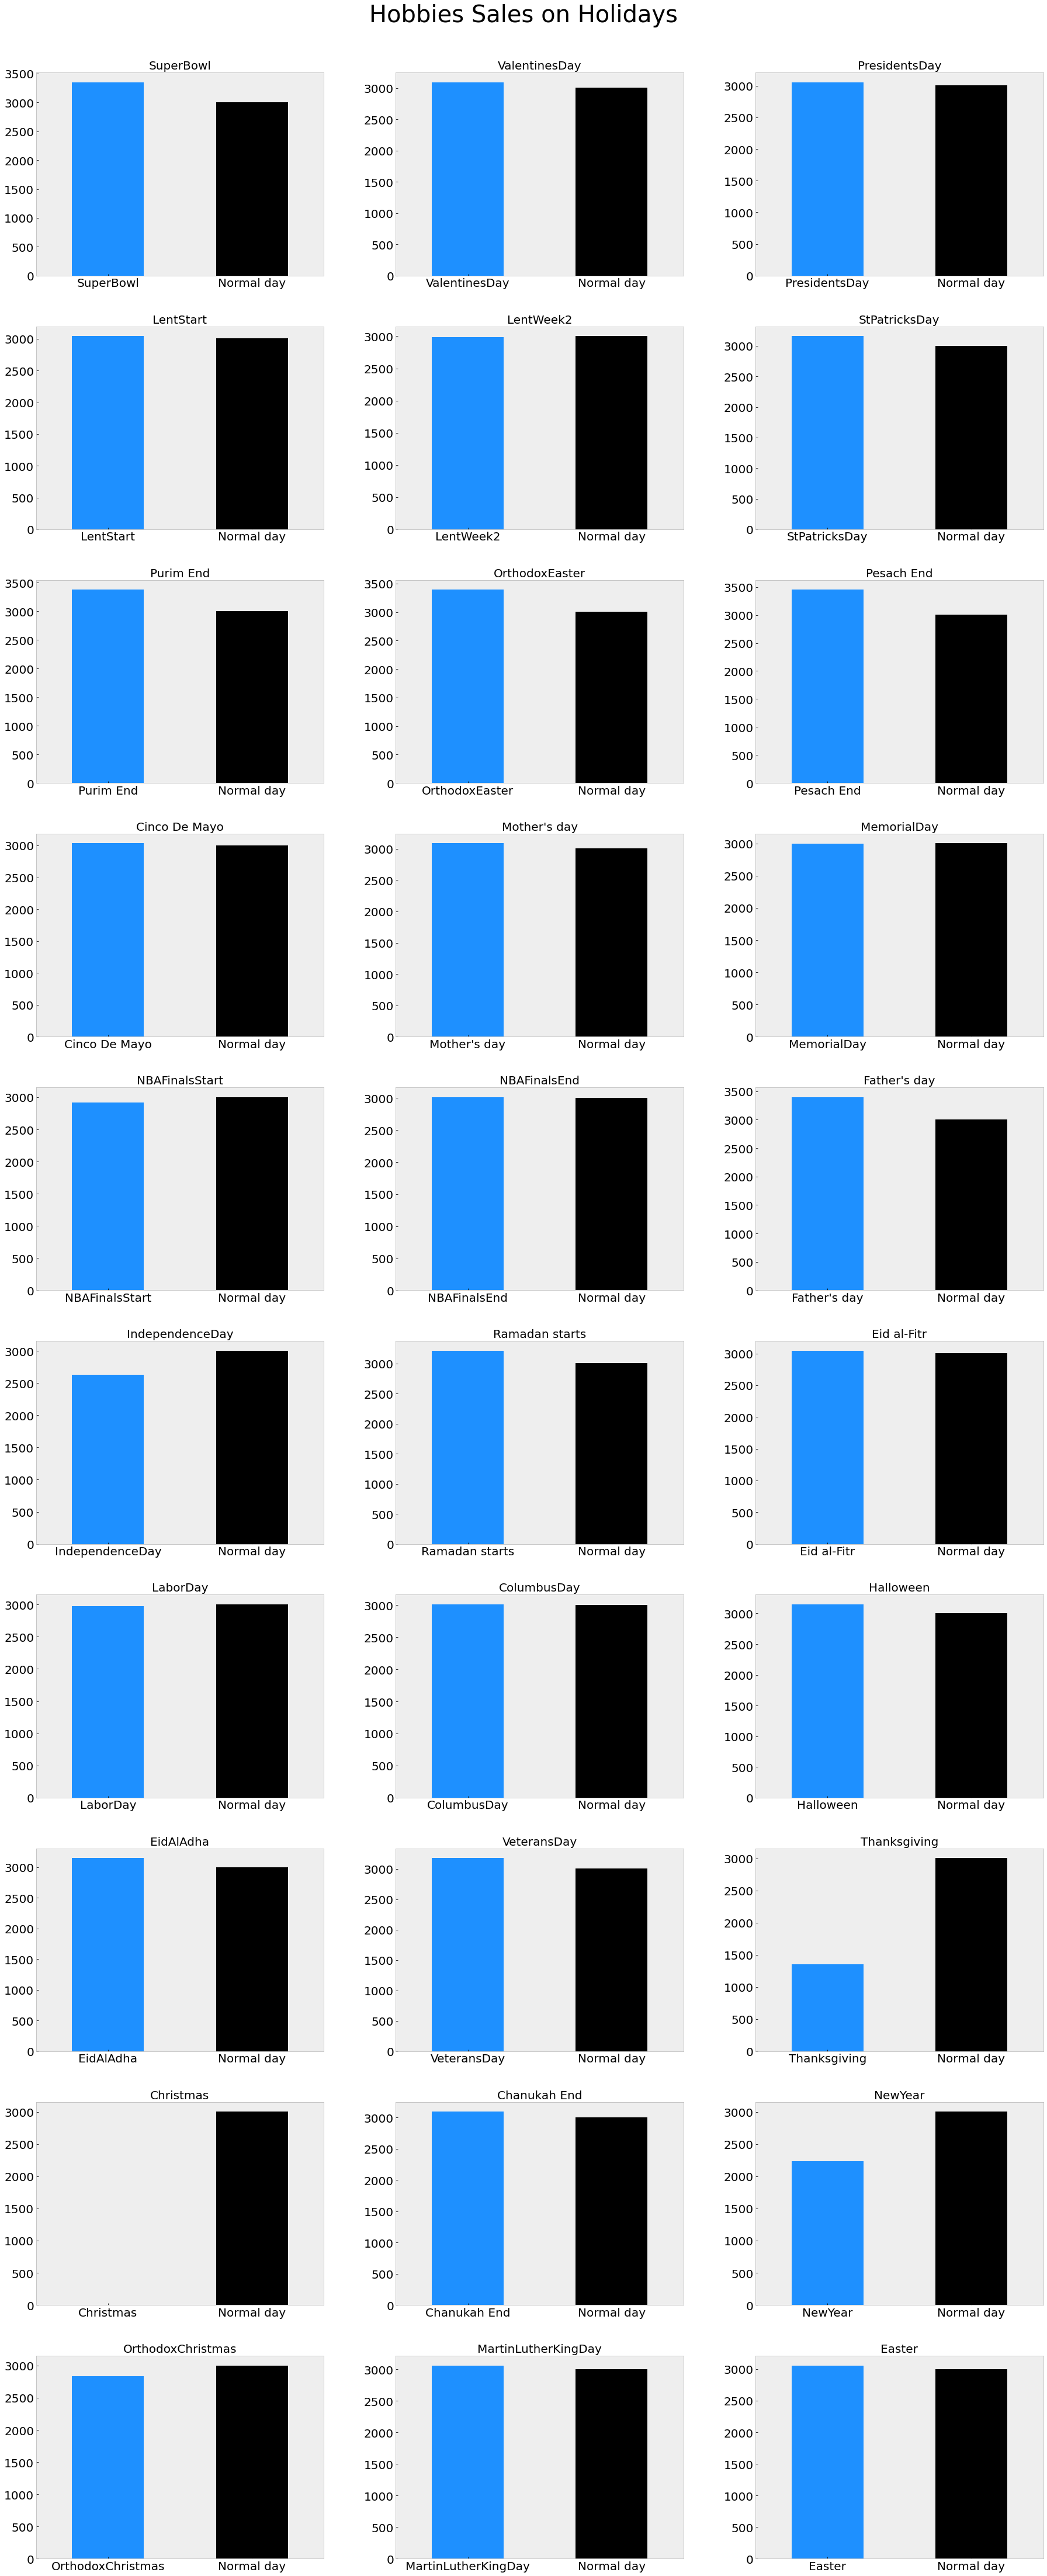

In [138]:
# Hobbies sale on holiday
fig, axes = plt.subplots(10,3,figsize=(25,60))

axes = axes.flatten()
ax_idx = 0

for ee in events:
    
    normal_day_sales = ss.loc[(ss.event_name_1.isnull()) & (ss.weekday != 'Saturday') & (ss.weekday != 'Sunday')] # sales on normal day
    nm = normal_day_sales['HOBBIES'].mean()  

    event_day = ss.loc[(ss.event_name_1 == ee)] # sale on the holiday
    em = event_day['HOBBIES'].mean()

    df = pd.DataFrame({'Type':[ee,'Normal day'],'Sale':[em,nm]}) # make new df
    
    df.plot(kind='bar',x='Type',y='Sale', title= ee, legend='', rot=0, color=['dodgerblue','black'], ax=axes[ax_idx])
    
    axes[ax_idx].set_title(ee, fontsize=20)
    axes[ax_idx].tick_params(axis='both', which='major', labelsize=20) # x y tick font size
    axes[ax_idx].set_xlabel('') # remove x label
    axes[ax_idx].grid(False) # remove grid
    
    ax_idx +=1
    
plt.tight_layout()
plt.suptitle('Hobbies Sales on Holidays', size=40, y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
    
    

# Effect of holidays on 'Household'
* Noticeable differences: SuperBowl, President Day, St Paricks Day, Purim End, Orthodox Easter, Pesach, Father's Day, Ramadan Starts, Eid al-Fitr, Labor Day,  Eid Al Adha, Martin Luther King day, Easter
* Noticeable lower on the holiday: Thanks Giving, Christmas, New Year, Orthodox Christmas

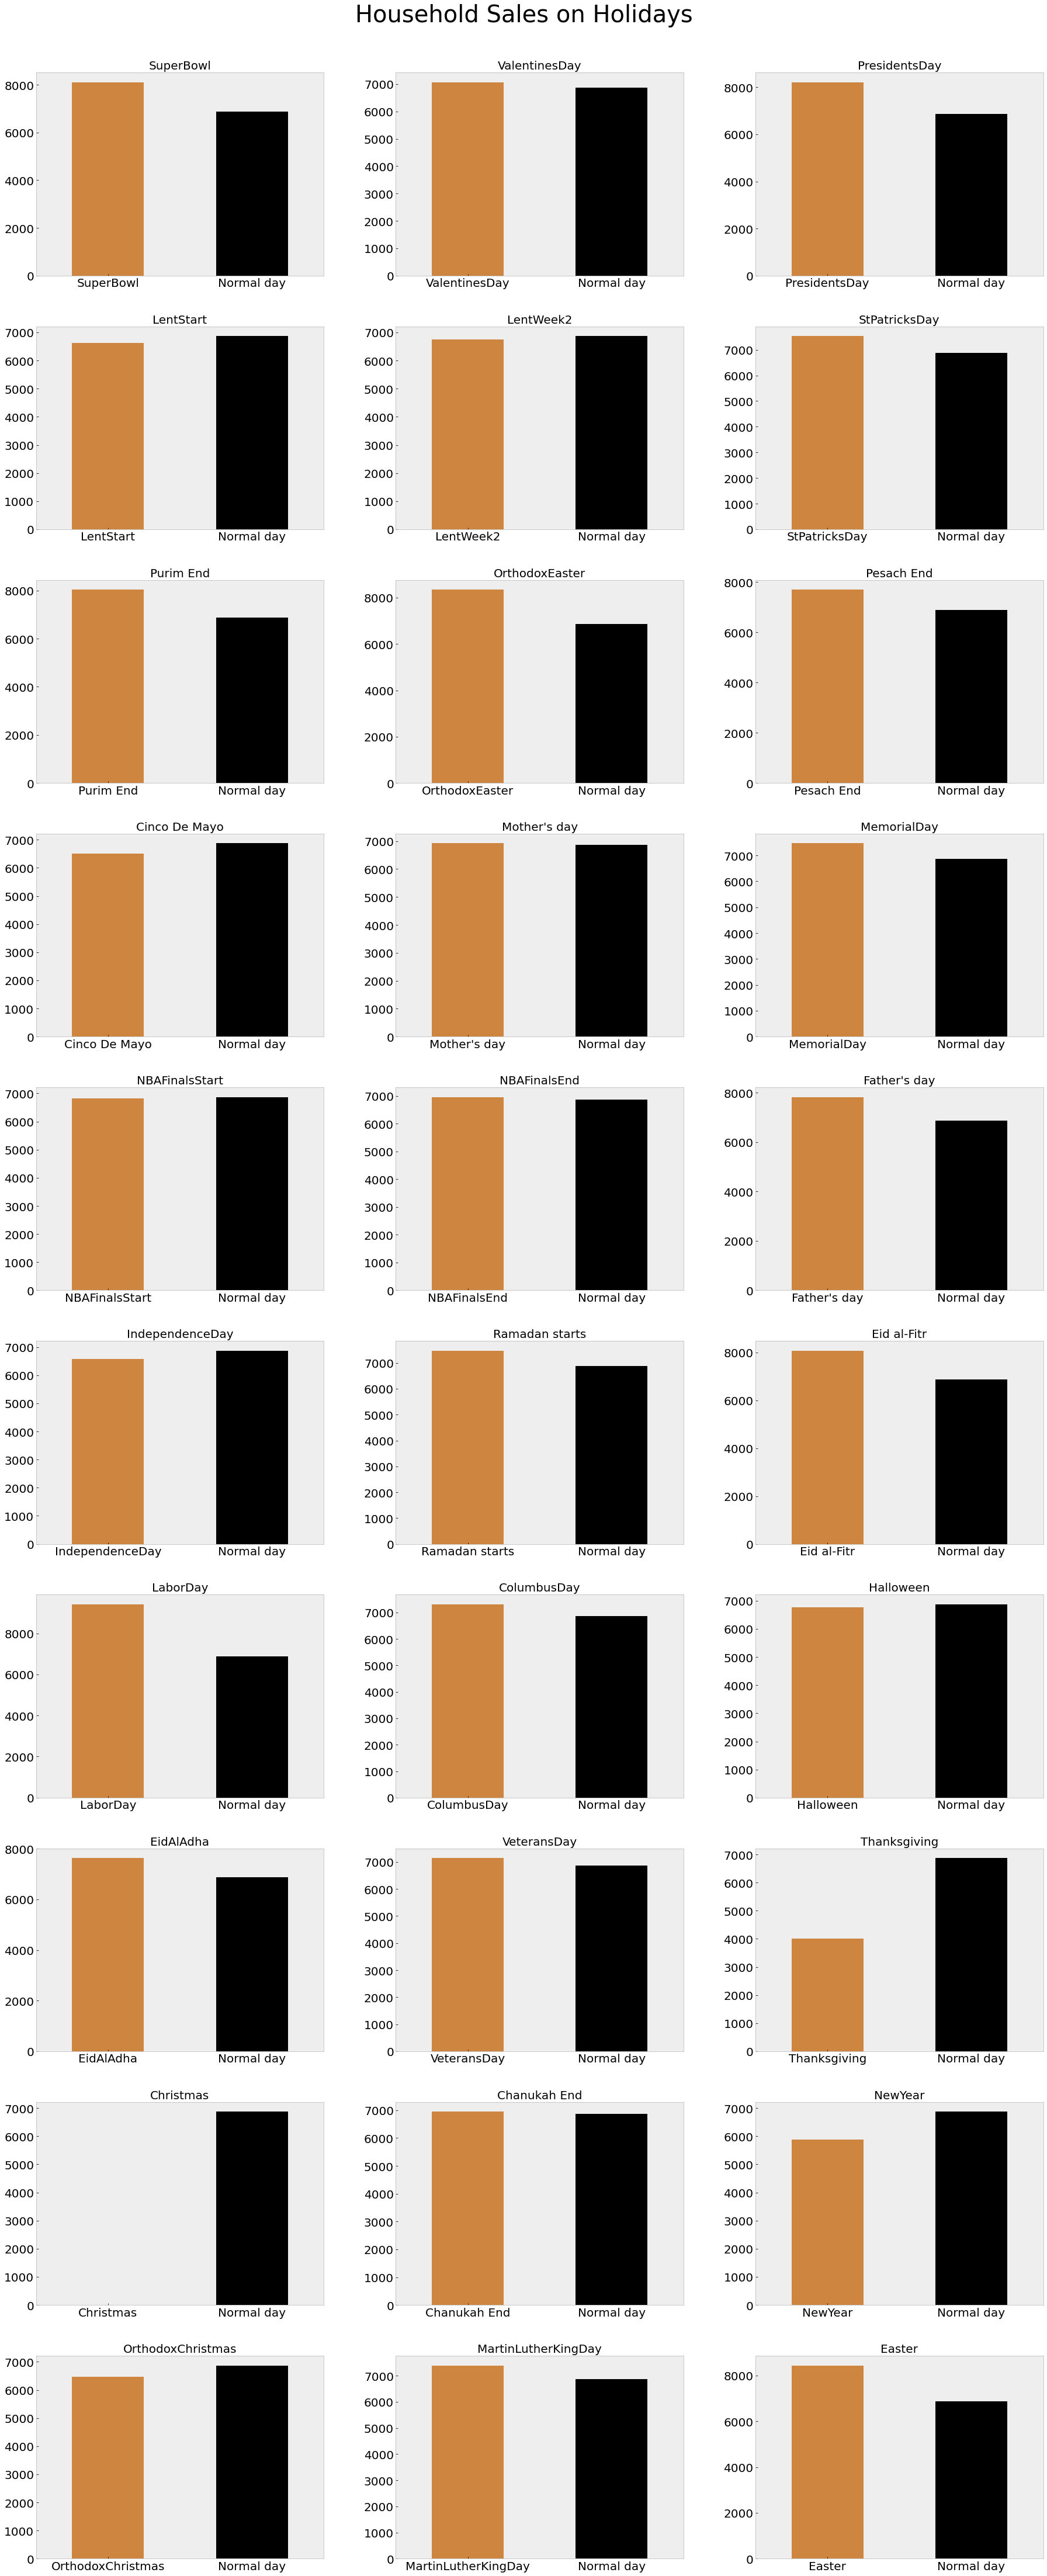

In [139]:
# Household sale on holiday
fig, axes = plt.subplots(10,3,figsize=(25,60))

axes = axes.flatten()
ax_idx = 0

for ee in events:
    
    normal_day_sales = ss.loc[(ss.event_name_1.isnull()) & (ss.weekday != 'Saturday') & (ss.weekday != 'Sunday')] # sales on normal day
    nm = normal_day_sales['HOUSEHOLD'].mean()  

    event_day = ss.loc[(ss.event_name_1 == ee)] # sale on the holiday
    em = event_day['HOUSEHOLD'].mean()

    df = pd.DataFrame({'Type':[ee,'Normal day'],'Sale':[em,nm]}) # make new df
    
    df.plot(kind='bar',x='Type',y='Sale', title= ee, legend='', rot=0, color=['peru','black'], ax=axes[ax_idx])

    axes[ax_idx].set_title(ee, fontsize=20)
    axes[ax_idx].tick_params(axis='both', which='major', labelsize=20) # x y tick font size
    axes[ax_idx].set_xlabel('') # remove x label
    axes[ax_idx].grid(False) # remove grid
    
    ax_idx +=1
    
plt.tight_layout()
plt.suptitle('Household Sales on Holidays', size=40, y=1.02)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
    


In [140]:
# event types, 'Sporting', 'Cultural', 'National', 'Religious'
event_types = ss.event_type_1.unique()
event_types = event_types[1:len(event_types)]

# 'Food' sales by type of holiday
* More 'Food' sales on Sports, Cultural, Religious holidays
* Less 'Food' sales on National holidays

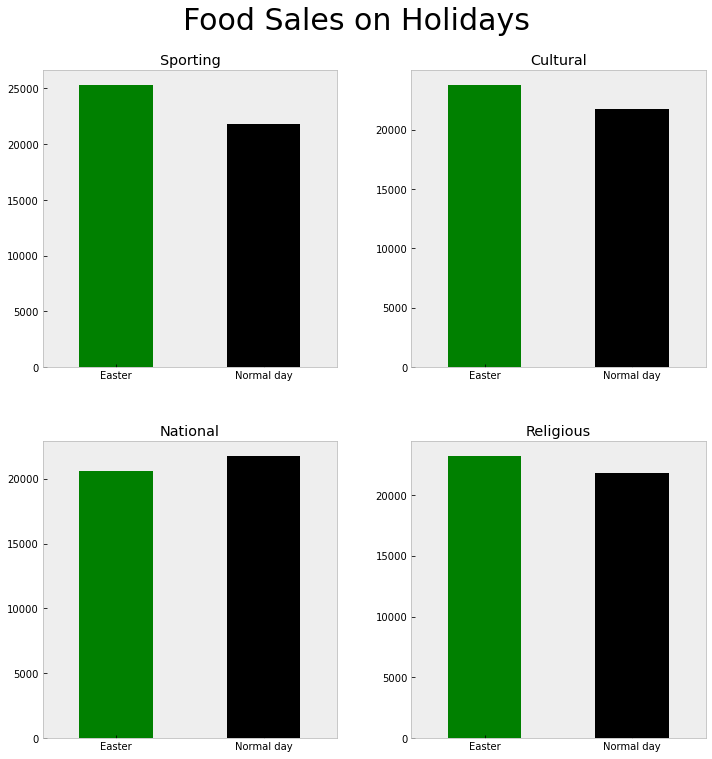

In [141]:
# Food sale on type holiday
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes = axes.flatten()
ax_idx = 0

for ep in event_types:
    
    normal_day_sales = ss.loc[(ss.event_type_1.isnull()) & (ss.weekday != 'Saturday') & (ss.weekday != 'Sunday')] # sales on normal day
    nm = normal_day_sales['FOODS'].mean()  

    event_day = ss.loc[(ss.event_type_1 == ep)] # sale on the holiday
    em = event_day['FOODS'].mean()

    df = pd.DataFrame({'Type':[ee,'Normal day'],'Sale':[em,nm]}) # make new df
    
    df.plot(kind='bar',x='Type',y='Sale', title= ep, legend='', rot=0, color=['green','black'], ax=axes[ax_idx])
    
    axes[ax_idx].set_xlabel('') # remove x label
    axes[ax_idx].grid(False) # remove grid
    
    ax_idx +=1
    
plt.tight_layout()
plt.suptitle('Food Sales on Holidays', size=30, y=1.05)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
    


# 'Hobbies' sales by type of holiday
* Slightly more 'Hobbies' sales on Sports, Cultural, Religious holidays
* Less 'Hobbies' sales on National holidays

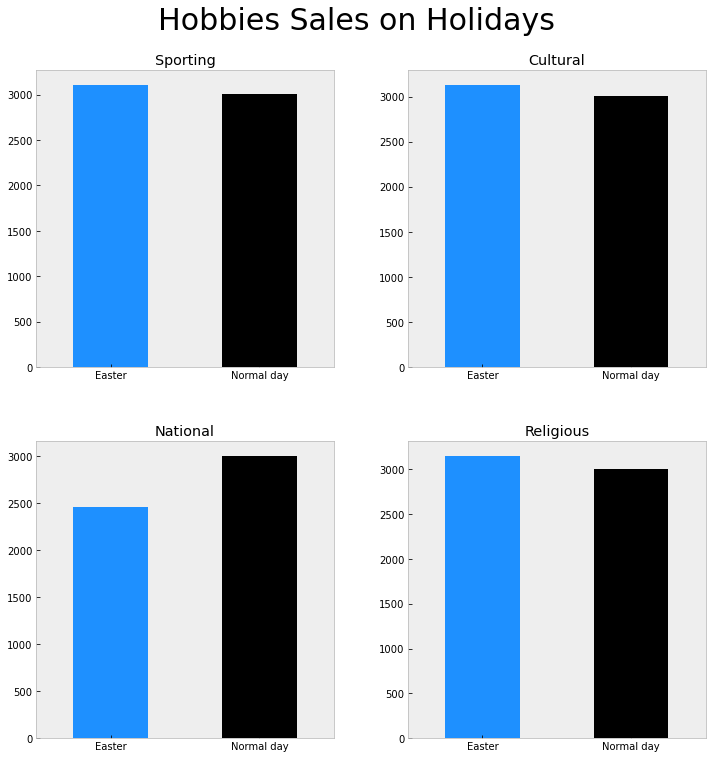

In [142]:
# Hobby sale on type holiday
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes = axes.flatten()
ax_idx = 0

for ep in event_types:
    
    normal_day_sales = ss.loc[(ss.event_type_1.isnull()) & (ss.weekday != 'Saturday') & (ss.weekday != 'Sunday')] # sales on normal day
    nm = normal_day_sales['HOBBIES'].mean()  

    event_day = ss.loc[(ss.event_type_1 == ep)] # sale on the holiday
    em = event_day['HOBBIES'].mean()

    df = pd.DataFrame({'Type':[ee,'Normal day'],'Sale':[em,nm]}) # make new df
    
    df.plot(kind='bar',x='Type',y='Sale', title= ep, legend='', rot=0, color=['dodgerblue','black'], ax=axes[ax_idx])
    
    axes[ax_idx].set_xlabel('') # remove x label
    axes[ax_idx].grid(False) # remove grid
    
    ax_idx +=1
    
plt.tight_layout()
plt.suptitle('Hobbies Sales on Holidays', size=30, y=1.05)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
    


# 'Household' sales by type of holiday
* Somewhat more 'Household' sales on Sports, Cultural, Religious holidays
* Less 'Household' sales on National holidays

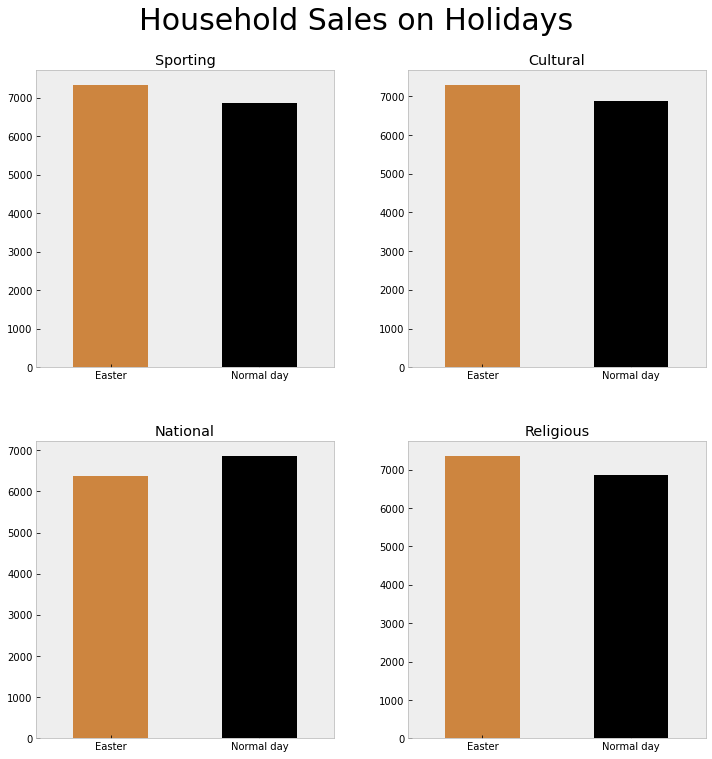

In [143]:
# Household sale on type holiday
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes = axes.flatten()
ax_idx = 0

for ep in event_types:
    
    normal_day_sales = ss.loc[(ss.event_type_1.isnull()) & (ss.weekday != 'Saturday') & (ss.weekday != 'Sunday')] # sales on normal day
    nm = normal_day_sales['HOUSEHOLD'].mean()  

    event_day = ss.loc[(ss.event_type_1 == ep)] # sale on the holiday
    em = event_day['HOUSEHOLD'].mean()

    df = pd.DataFrame({'Type':[ee,'Normal day'],'Sale':[em,nm]}) # make new df
    
    df.plot(kind='bar',x='Type',y='Sale', title= ep, legend='', rot=0, color=['peru','black'], ax=axes[ax_idx])
    
    axes[ax_idx].set_xlabel('') # remove x label
    axes[ax_idx].grid(False) # remove grid
    
    ax_idx +=1
    
plt.tight_layout()
plt.suptitle('Household Sales on Holidays', size=30, y=1.05)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
    
